In [41]:
# set the matplotlib backend so figures can be saved in the background
%matplotlib inline
# matplotlib.use("Agg")

from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [44]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
tf.keras.backend.set_session(tf.Session(config=config))

# import the necessary packages
from pyimagesearch.trafficsignnet import TrafficSignNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [16]:
tf.test.is_gpu_available()

True

# Data preparation

In [17]:
def load_split(basePath, csvPath):
	# initialize the list of data and labels
	data = []
	labels = []

	# load the contents of the CSV file, remove the first line (since
	# it contains the CSV header), and shuffle the rows (otherwise
	# all examples of a particular class will be in sequential order)
	rows = open(csvPath).read().strip().split("\n")[1:]
	random.shuffle(rows)

	# loop over the rows of the CSV file
	for (i, row) in enumerate(rows):
		# check to see if we should show a status update
		if i > 0 and i % 1000 == 0:
			print("[INFO] processed {} total images".format(i))

		# split the row into components and then grab the class ID
		# and image path
		(label, imagePath) = row.strip().split(",")[-2:]

		# derive the full path to the image file and load it
		imagePath = os.path.sep.join([basePath, imagePath])
		image = io.imread(imagePath)

		# resize the image to be 32x32 pixels, ignoring aspect ratio,
		# and then perform Contrast Limited Adaptive Histogram
		# Equalization (CLAHE)
		image = transform.resize(image, (32, 32))
		image = exposure.equalize_adapthist(image, clip_limit=0.1)

		# update the list of data and labels, respectively
		data.append(image)
		labels.append(int(label))

	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)

	# return a tuple of the data and labels
	return (data, labels)

In [18]:
dataset_location = "gtsrb-german-traffic-sign" #path to input GTSRB
model_output_name = "output/trafficsignnet"+str(int(time.time()))+".model" #path to output model
plot = "output/plot.png" #path to training history plot

In [20]:
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64

In [21]:
# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

In [22]:
labelNames

['Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'End of speed limit (80km/h)',
 'Speed limit (100km/h)',
 'Speed limit (120km/h)',
 'No passing',
 'No passing for vehicles over 3.5 metric tons',
 'Right-of-way at the next intersection',
 'Priority road',
 'Yield',
 'Stop',
 'No vehicles',
 'Vehicles over 3.5 metric tons prohibited',
 'No entry',
 'General caution',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Double curve',
 'Bumpy road',
 'Slippery road',
 'Road narrows on the right',
 'Road work',
 'Traffic signals',
 'Pedestrians',
 'Children crossing',
 'Bicycles crossing',
 'Beware of ice/snow',
 'Wild animals crossing',
 'End of all speed and passing limits',
 'Turn right ahead',
 'Turn left ahead',
 'Ahead only',
 'Go straight or right',
 'Go straight or left',
 'Keep right',
 'Keep left',
 'Roundabout mandatory',
 'End of no passing',
 'End of no passing 

In [23]:
# derive the path to the training and testing CSV files
trainPath = os.path.sep.join([dataset_location, "Train.csv"])
testPath = os.path.sep.join([dataset_location, "Test.csv"])

In [13]:
# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX, trainY) = load_split(dataset_location, trainPath)
(testX, testY) = load_split(dataset_location, testPath)

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total images
[INFO] processed 27000 total 

In [24]:
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

In [27]:
# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [28]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# Building the model and training

In [29]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNet.build(width=32, height=32, depth=3, classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [30]:
# compile the model and train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    verbose=1)

[INFO] training network...
Epoch 1/30
612/612 [==============================] - 14s 22ms/step - loss: 2.6331 - acc: 0.3049 - val_loss: 2.6547 - val_acc: 0.2699
Epoch 2/30
612/612 [==============================] - 12s 19ms/step - loss: 1.3125 - acc: 0.5831 - val_loss: 0.6717 - val_acc: 0.7735
Epoch 3/30
612/612 [==============================] - 12s 19ms/step - loss: 0.8536 - acc: 0.7281 - val_loss: 0.5187 - val_acc: 0.8252
Epoch 4/30
612/612 [==============================] - 12s 19ms/step - loss: 0.6295 - acc: 0.7995 - val_loss: 0.3676 - val_acc: 0.8819
Epoch 5/30
612/612 [==============================] - 12s 19ms/step - loss: 0.4896 - acc: 0.8436 - val_loss: 0.2823 - val_acc: 0.9089
Epoch 6/30
612/612 [==============================] - 12s 19ms/step - loss: 0.4099 - acc: 0.8703 - val_loss: 1.4158 - val_acc: 0.6439
Epoch 7/30
612/612 [==============================] - 12s 19ms/step - loss: 0.3494 - acc: 0.8899 - val_loss: 0.3335 - val_acc: 0.8983
Epoch 8/30
612/612 [===============

# Model evaluation

In [31]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.98      0.77      0.86        60
                              Speed limit (30km/h)       0.92      0.99      0.95       720
                              Speed limit (50km/h)       0.99      0.95      0.97       750
                              Speed limit (60km/h)       1.00      0.84      0.91       450
                              Speed limit (70km/h)       0.99      0.96      0.97       660
                              Speed limit (80km/h)       0.87      0.89      0.88       630
                       End of speed limit (80km/h)       0.79      0.81      0.80       150
                             Speed limit (100km/h)       0.81      0.99      0.89       450
                             Speed limit (120km/h)       0.94      0.97      0.95       450
                                        No passing

In [33]:
# save the network to disk
print("[INFO] serializing network to '{}'...".format(model_output_name))
model.save(model_output_name)

[INFO] serializing network to 'output/trafficsignnet1572968296.model'...


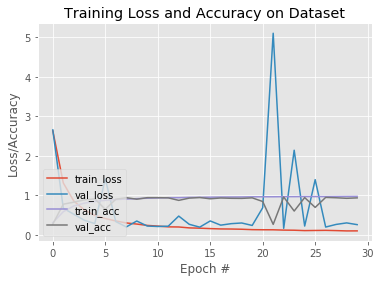

In [42]:
# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig(plot)
plt.show()

# Predictions on test images

In [57]:
import imutils
from imutils import paths
import cv2

Load the trained model

In [45]:
# load the traffic sign recognizer model
print("[INFO] loading model...")
model = load_model(model_output_name)

[INFO] loading model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Choose test images by their path

In [51]:
# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

# grab the paths to the input images, shuffle them, and grab a sample
INPUT_IMAGES_PATH = "gtsrb-german-traffic-sign/Test"
imagePaths = list(paths.list_images(INPUT_IMAGES_PATH))
random.shuffle(imagePaths)
imagePaths = imagePaths[:25]

In [53]:
imagePaths[:3]

['gtsrb-german-traffic-sign/Test/06524.png',
 'gtsrb-german-traffic-sign/Test/03058.png',
 'gtsrb-german-traffic-sign/Test/00420.png']

Do predictions and write them to a folder

In [58]:
PATH_TO_WRITE_IMAGES = "examples"
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # load the image, resize it to 32x32 pixels, and then apply
    # Contrast Limited Adaptive Histogram Equalization (CLAHE),
    # just like we did during training
    image = io.imread(imagePath)
    image = transform.resize(image, (32, 32))
    image = exposure.equalize_adapthist(image, clip_limit=0.1)

    # preprocess the image by scaling it to the range [0, 1]
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)

    # make predictions using the traffic sign recognizer CNN
    preds = model.predict(image)
    j = preds.argmax(axis=1)[0]
    label = labelNames[j]

    # load the image using OpenCV, resize it, and draw the label
    # on it
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=128)
    cv2.putText(image, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX,
        0.45, (0, 0, 255), 2)

    # save the image to disk
    p = os.path.sep.join([PATH_TO_WRITE_IMAGES, "{}.png".format(i)])
    cv2.imwrite(p, image)